In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

import re
from tqdm import tqdm
from tqdm import tnrange
from tqdm import tqdm_notebook
from wordcloud import WordCloud

import nltk
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.decomposition import NMF
from sklearn.feature_extraction import stop_words as sklearn_stopwords
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

from gensim import corpora
from gensim import models
from gensim import similarities
from gensim import matutils
from gensim.parsing.preprocessing import STOPWORDS as gensim_stopwords

from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords as nltk_stopwords
from nltk.tokenize import sent_tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

import textblob

import pickle
from pymongo import MongoClient
from bson import json_util

In [2]:
%matplotlib inline

# custom_style = {'axes.labelcolor': 'white',
#                 'xtick.color': 'white',
#                 'ytick.color': 'white'}
# sns.set_style("darkgrid", rc=custom_style)

### Presidents List

In [3]:
pres_list = pd.read_csv('https://gist.githubusercontent.com/namuol/2657233/raw/74135b2637e624848c163759be9cd14ae33f5153/presidents.csv')

### JSON-Pandas Stuff

In [4]:
json_file = '/home/cneiderer/Downloads/presidency.json'

In [5]:
# Load presidential json data into df
pres_df = pd.read_json(json_file)
# Convert from wide to long format
pres_df = pres_df.T
# Subset data on oral and written speeches
pres_df = pres_df[['Oral', 'Written']]

In [6]:
# Transform into more usable format
df = pd.DataFrame()
for idx in tnrange(len(pres_df.index)):
    pres = pres_df.index[idx]
    pres_data = pres_df.loc[pres]
    
    speech_type = ['Oral', 'Written']
    for jdx in tnrange(len(speech_type)):
        tmp_df = pd.DataFrame.from_dict(pres_df.loc[pres][speech_type[jdx]])
        tmp_df.insert(0, 'President', pres)
        tmp_df.insert(1, 'Type', speech_type[jdx])
        try:
            tmp_df.document_date = pd.to_datetime(tmp_df.document_date)
        except:
            tmp_df.document_data = pd.to_datetime('20500101')
        df = pd.concat([df, tmp_df], axis=0)

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

A Jupyter Widget

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 58595 entries, 0 to 48
Data columns (total 8 columns):
President        58595 non-null object
Type             58595 non-null object
category         58595 non-null object
content          58595 non-null object
document_date    58595 non-null datetime64[ns]
pid              58595 non-null float64
subcategory      41464 non-null object
title            58595 non-null object
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 4.0+ MB


### Sentiment

In [9]:
corpus = df['content']

In [13]:
sentiment = []
for idx in tnrange(len(corpus)):
    sentiment.append(textblob.TextBlob(corpus.iloc[idx]).sentiment)

A Jupyter Widget

In [52]:
sentiment_df = pd.DataFrame(sentiment)

In [24]:
# pickle sentiment results
pickle_file = 'APP_sentiment_results.pickle'
with open(pickle_file, 'wb') as f:
    pickle.dump(sentiment_df, f)
    
# with open(pickle_file, 'rb') as f:
#     tmp = pickle.load(f)

In [ ]:
df.index = range(0, df.shape[0])

In [67]:
sorted_sentiment = pd.concat([df.document_date, sentiment_df], axis=1).sort_values('document_date')

In [68]:
sorted_sentiment.head()

,document_date,polarity,subjectivity
23555,1789-04-30,0.204100,0.429194
23565,1789-05-08,0.234399,0.546350
23566,1789-05-18,0.303571,0.505782
23567,1789-05-25,-0.010000,0.420000
23568,1789-06-11,0.056602,0.277706


In [70]:
sorted_sentiment.describe()

,polarity,subjectivity
count,58595.000000,58595.000000
mean,0.131433,0.419668
std,0.107275,0.124746
min,-1.000000,0.000000
25%,0.062500,0.369864
50%,0.130917,0.438129
75%,0.195455,0.490416
max,1.000000,1.000000


/home/cneiderer/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: pd.rolling_median is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=50,min_periods=1,center=False).median()
  if __name__ == '__main__':


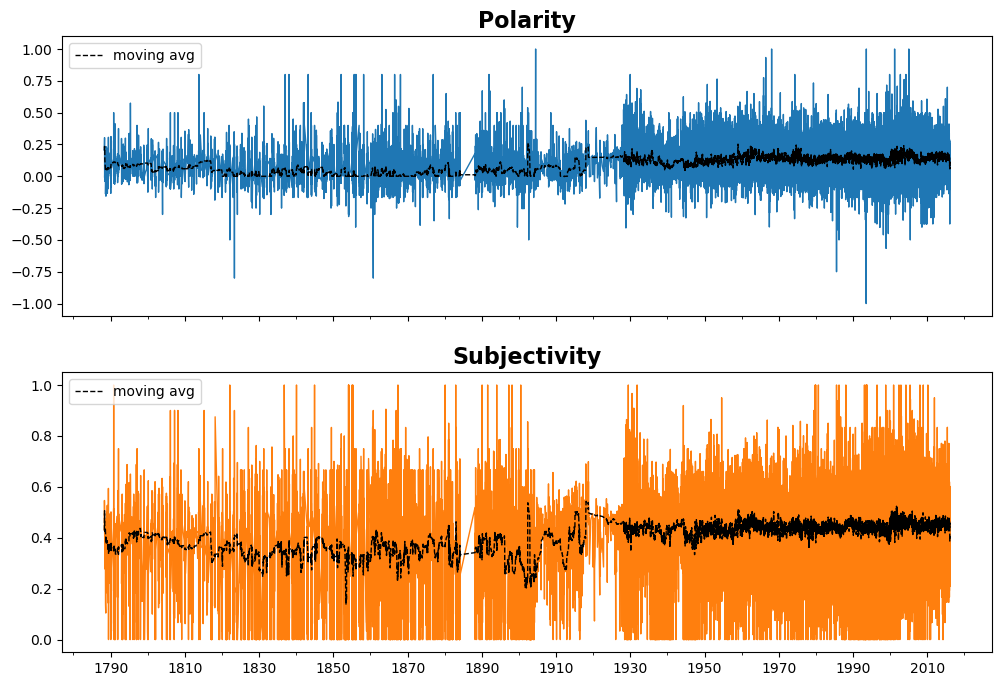

In [243]:
fig, axes = plt.subplots(2, 1, figsize=(12, 8))
window_sz = 50
colors = axes[0]._get_lines
for idx, col in enumerate(['polarity', 'subjectivity']):
    axes[idx].plot(sorted_sentiment.document_date, 
                   sorted_sentiment[col], 
                   c=colors.get_next_color(), ls='-', lw=1, label='_no_legend_')
    axes[idx].plot(sorted_sentiment.document_date, 
                   pd.rolling_median(sorted_sentiment[col], window_sz, 1), 
                   c='k', ls='--', lw=1, label='moving avg')
    
    axes[idx].set_title(col.capitalize(), fontsize=16, fontweight='bold')
    axes[idx].set_xticks(pd.date_range('1790-01-01', '2020-01-01', freq='20Y'))
    axes[idx].set_xticks(pd.date_range('1780-01-01', '2030-01-01', freq='20Y'), minor=True)
    if idx == 0:
        axes[idx].set_xticklabels([])
    
    axes[idx].legend()

In [180]:
np.arange(-0.2, -0.8, -0.1)

array([-0.2, -0.3, -0.4, -0.5, -0.6, -0.7, -0.8])

In [196]:
# negative sentiment
for val in np.arange(-0.0, -0.8, -0.1):
    tmp = sorted_sentiment[(sorted_sentiment.polarity < val)]
    print(val, tmp.shape)

# positive sentiment
for val in np.arange(0.0, 0.8, 0.1):
    tmp = sorted_sentiment[(sorted_sentiment.polarity > val)]
    print(val, tmp.shape)

-0.0 (4661, 3)
-0.1 (681, 3)
-0.2 (133, 3)
-0.3 (46, 3)
-0.4 (13, 3)
-0.5 (5, 3)
-0.6 (4, 3)
-0.7 (4, 3)
0.0 (51561, 3)
0.1 (36508, 3)
0.2 (13691, 3)
0.3 (3096, 3)
0.4 (693, 3)
0.5 (161, 3)
0.6 (58, 3)
0.7 (32, 3)


In [200]:
# negative sentiment
for val in np.arange(0.4, 0, -0.1):
    tmp = sorted_sentiment[(sorted_sentiment.subjectivity < val)]
    print(val, tmp.shape)

# positive sentiment
for val in np.arange(0.6, 1, 0.1):
    tmp = sorted_sentiment[(sorted_sentiment.subjectivity > val)]
    print(val, tmp.shape)

0.4 (19804, 3)
0.3 (7666, 3)
0.2 (3496, 3)
0.1 (1915, 3)
0.6 (2231, 3)
0.7 (468, 3)
0.8 (155, 3)
0.9 (65, 3)


In [217]:
tmp = df[sentiment_df.polarity > 0.4]
tmp.shape

(693, 8)

In [214]:
sentiment_df.iloc[181, :]

polarity        0.80
subjectivity    0.75
Name: 181, dtype: float64

In [213]:
tmp

,President,Type,category,content,document_date,pid,subcategory,title
181,Abraham Lincoln,Written,Messages,To the Senate of the United States: I transmit...,1864-01-29,69939.0,to Congress,Special Message
988,Andrew Johnson,Written,Messages,To the Senate of the United States: I transmit...,1867-07-06,72108.0,to Congress,Special Message
1142,Andrew Johnson,Written,Messages,To the House of Representatives of the United ...,1869-01-29,72329.0,to Congress,Special Message
6332,Barack Obama,Written,Statements,"On Sunday, many around the world will observe ...",2010-11-19,88737.0,(non categorized),Statement on the Anniversary of the Birth of t...
6823,Barack Obama,Written,Statements,"For more than 40 years, from his service on th...",2015-11-13,111137.0,(non categorized),806 - Statement on Representative Samuel S. F...
6854,Barack Obama,Written,Statements,"For more than 20 years, Representative Mark Ta...",2016-05-20,117420.0,(non categorized),337 - Statement on Representative K. Mark Tak...
7460,Benjamin Harrison,Oral,Remarks,It gives me pleasure to consummate here to-day...,1893-02-22,76220.0,(non categorized),Remarks Hoisting the Flag on the Steamship New...
7544,Benjamin Harrison,Written,Messages,To the Senate and House of Representatives: Th...,1891-02-13,70992.0,to Congress,Message to Congress Announcing the Death of Ad...
7596,Benjamin Harrison,Written,Messages,To the Senate: In response to the resolution o...,1892-12-07,71133.0,to Congress,Special Message
9071,Dwight D. Eisenhower,Oral,Remarks,"I AM VERY HAPPY, in the presence of this disti...",1954-05-13,9887.0,Bill Signings,110 - Remarks Upon Signing the St. Lawrence S...


In [218]:
list(tmp[tmp.index==30669].content)

['To the Senate of the United States: I transmit herewith a report of the Secretary of State, with accompanying papers, submitted in response to the Senate resolution of the 12th ultimo, touching the case of Michael P. Boyton.*JAMES A. GARFIELD *Arrested and imprisoned by authorities of Great Britain.']

In [233]:
'test'.capitalize()

'Test'